In [1]:
import pandas as pd
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dfs = {}
for label in labels:
    dfs[label] = pd.read_csv("data"+str(label)+".csv", sep=",")


In [2]:
x_raw = []
y = []

for label, df in dfs.items():
    data = []
    for i, row in df.iterrows():
        if row["accel_data0"] != "break":
            data.append(row.astype(float).values.tolist())
        else:
            
            x_raw.append(data)
            y.append(label)
            data = []


In [3]:
def resample_signal(signal_list, desired_length):
    def resample_channel(channel, desired_length):
        current_length = len(channel)
        if current_length == desired_length:
            return channel

        resampled_channel = []
        ratio = current_length / desired_length

        for i in range(desired_length):
            original_index = i * ratio
            index1 = int(original_index)
            index2 = min(index1 + 1, current_length - 1)
            weight = original_index - index1
            resampled_value = channel[index1] * (1 - weight) + channel[index2] * weight
            resampled_channel.append(resampled_value)

        min_original = min(channel)
        max_original = max(channel)
        min_resampled = min(resampled_channel)
        max_resampled = max(resampled_channel)
        
        if max_resampled != min_resampled:
            resampled_channel = [
                (value - min_resampled) / (max_resampled - min_resampled) * (max_original - min_original) + min_original
                for value in resampled_channel
            ]
        return resampled_channel
    transposed_signal = list(map(list, zip(*signal_list)))
    resampled_transposed_signal = [
        resample_channel(channel, desired_length) for channel in transposed_signal
    ]
    resampled_signal = list(map(list, zip(*resampled_transposed_signal)))
    return resampled_signal

In [4]:
x = []
for i, sample in enumerate(x_raw):
    resampled = resample_signal(sample, 20)
    list_1d = [item for sublist in resampled for item in sublist]
    if len(list_1d) == 120: 
        x.append(list_1d)
        #print(len(list_1d))
    else:
        y.pop(i)
    


In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from everywhereml.sklearn.ensemble import RandomForestClassifier
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from statistics import mean
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

max_leaf_nodes = np.arange(10, 20, 1)
n_estimators = np.arange(10, 20, 1)
skf = StratifiedKFold(n_splits=3)
best_nodes = 0
best_n_est = 0
best_acc = 0
for nodes, n_est in itertools.product(max_leaf_nodes, n_estimators):
    for j, (train_index, val_index) in enumerate(skf.split(x, y)):
        x_train = [x[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        x_val = [x[i] for i in val_index]
        y_val = [y[i] for i in val_index]
        acc = []
        clf = RandomForestClassifier(n_estimators=n_est, max_leaf_nodes=nodes)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        y_true = y_val
        acc.append(accuracy_score(y_true, y_pred))
    print('n_nodes: ',nodes, ' n_estimators: ', n_est,' accuracy: ', mean(acc))
    if mean(acc)>best_acc:
        best_nodes = nodes
        best_n_est = n_est
        best_acc = mean(acc)
print('best model = n_nodes: ',best_nodes, ' n_estimators: ', best_n_est,' accuracy: ', best_acc)

n_nodes:  10  n_estimators:  10  accuracy:  0.7678571428571429
n_nodes:  10  n_estimators:  11  accuracy:  0.7678571428571429
n_nodes:  10  n_estimators:  12  accuracy:  0.7797619047619048
n_nodes:  10  n_estimators:  13  accuracy:  0.7738095238095238
n_nodes:  10  n_estimators:  14  accuracy:  0.7559523809523809
n_nodes:  10  n_estimators:  15  accuracy:  0.7916666666666666
n_nodes:  10  n_estimators:  16  accuracy:  0.7976190476190477
n_nodes:  10  n_estimators:  17  accuracy:  0.7559523809523809
n_nodes:  10  n_estimators:  18  accuracy:  0.7976190476190477
n_nodes:  10  n_estimators:  19  accuracy:  0.75
n_nodes:  11  n_estimators:  10  accuracy:  0.7559523809523809
n_nodes:  11  n_estimators:  11  accuracy:  0.7738095238095238
n_nodes:  11  n_estimators:  12  accuracy:  0.7321428571428571
n_nodes:  11  n_estimators:  13  accuracy:  0.7619047619047619
n_nodes:  11  n_estimators:  14  accuracy:  0.7559523809523809
n_nodes:  11  n_estimators:  15  accuracy:  0.7678571428571429
n_node

0.9276315789473685
0.9269330207692276


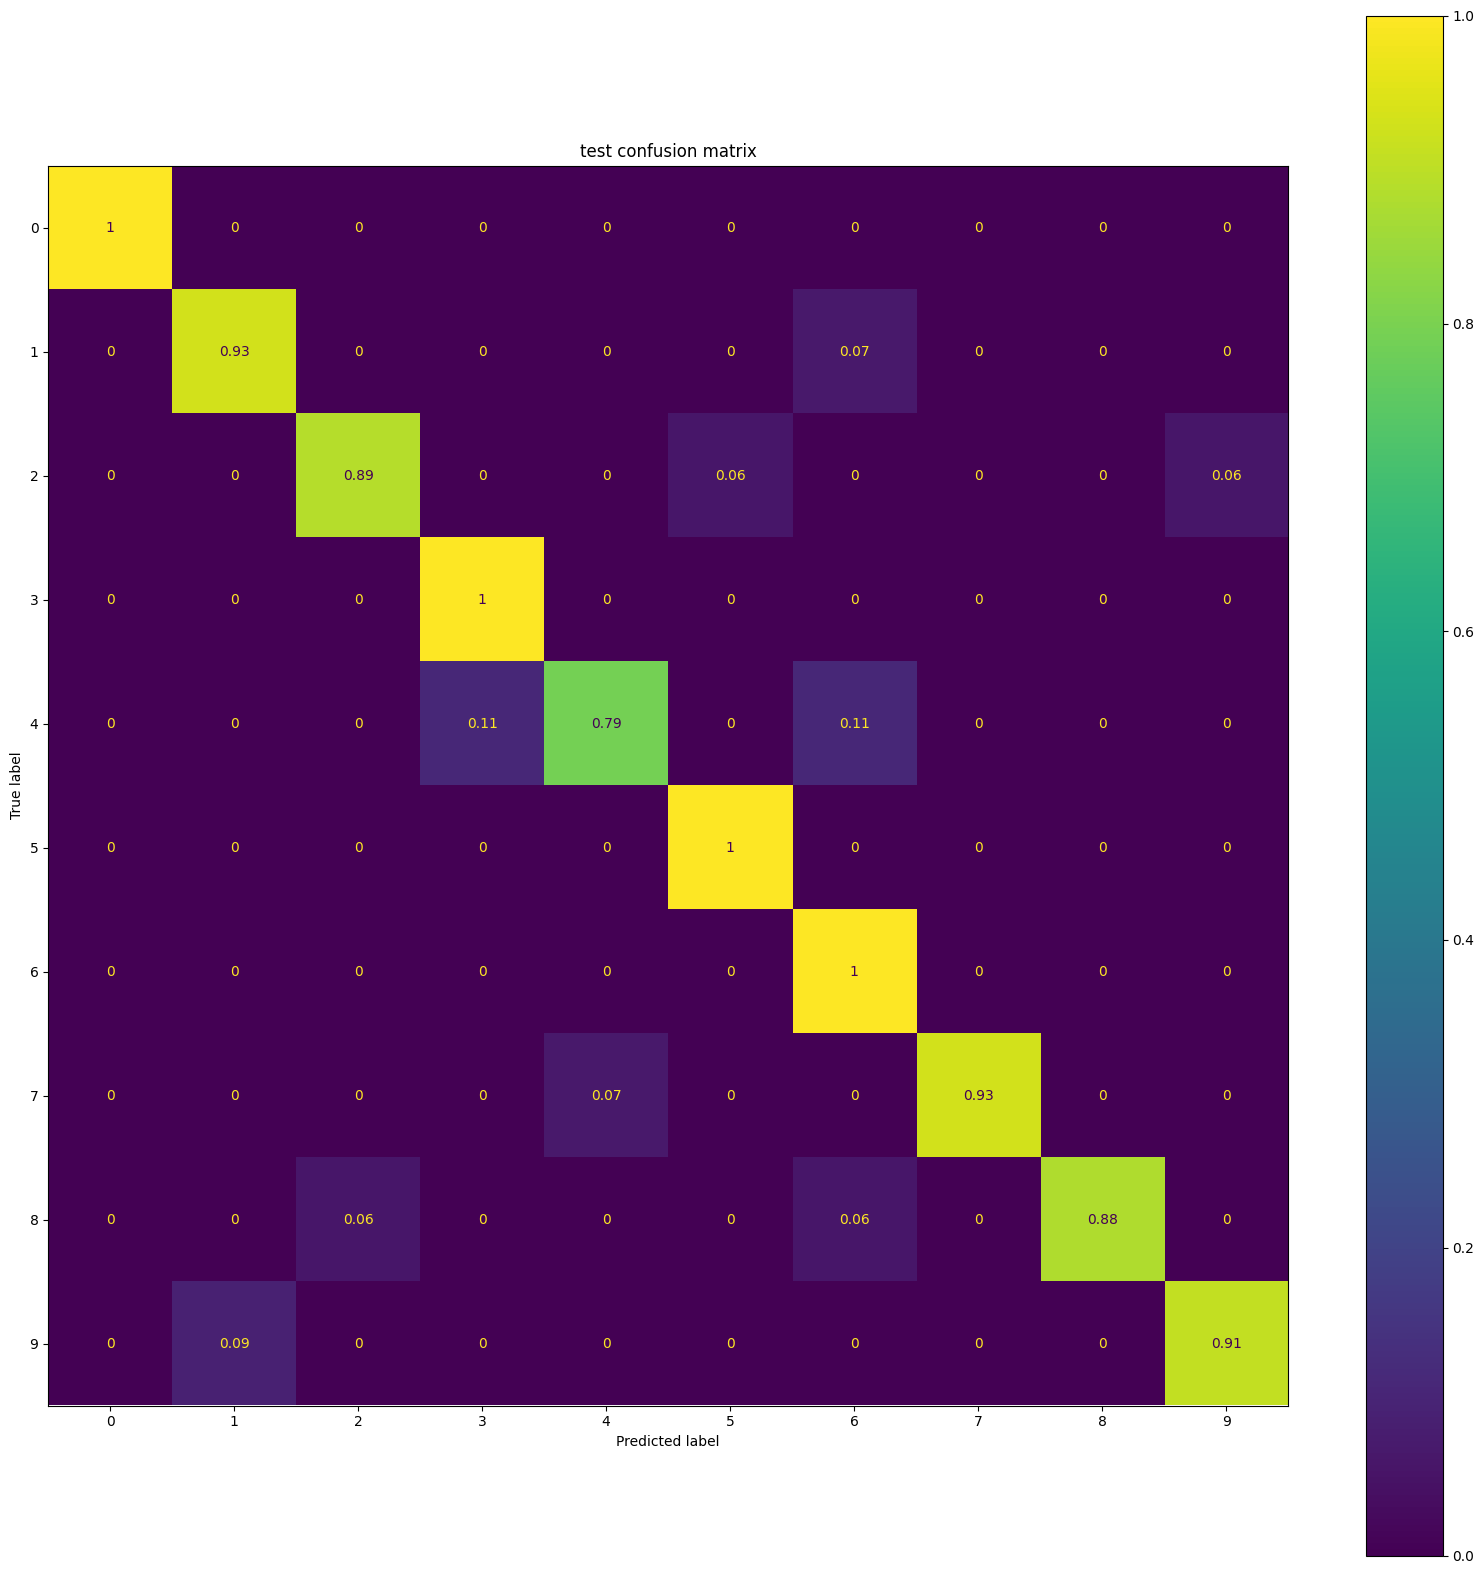

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3)
best_clf = RandomForestClassifier(n_estimators=best_n_est, max_leaf_nodes=best_nodes)
best_clf.fit(x_train, y_train)
pred = best_clf.predict(x_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred, average='macro'))
cm = confusion_matrix(y_test, pred)
cm = normalize(cm, norm='l1')
cm = np.round(cm, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax)
plt.title('test confusion matrix')
plt.show()

In [7]:
best_clf.to_micropython_file("MyModel.py")

'try:\n    from time import ticks_us, ticks_diff\nexcept ImportError:\n    from time import time_ns\n\n    def ticks_us(): return int(time_ns() * 1000)\n    def ticks_diff(a, b): return a - b\n\nclass RandomForestClassifier:\n    """\n    # RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_name=RandomForestClassifier, class_weight=None, criterion=gini, estimator=DecisionTreeClassifier(), estimator_params=(\'criterion\', \'max_depth\', \'min_samples_split\', \'min_samples_leaf\', \'min_weight_fraction_leaf\', \'max_features\', \'max_leaf_nodes\', \'min_impurity_decrease\', \'random_state\', \'ccp_alpha\', \'monotonic_cst\'), max_depth=None, max_features=sqrt, max_leaf_nodes=16, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, monotonic_cst=None, n_estimators=16, n_jobs=None, num_outputs=10, oob_score=False, package_name=everywhereml.sklearn.ensemble, random_state=None, template_folder=everywhereml/sklearn/ensem